In [ ]:
! pip install split-folders

In [28]:
import tensorflow as tf
from tensorflow import keras

Analysing the data

In [50]:
import os
import pandas as pd
src_dir=r'C:\dataset'
cat=['final']
lst=[]
for i in cat:
    cat_path=os.path.join(src_dir,i)
    classes=os.listdir(cat_path)
    for j in classes:
        class_path=os.path.join(cat_path,j)
        for k in os.listdir(class_path):
            lst.append([os.path.join(class_path,k),j])
df=pd.DataFrame(lst,columns=['Path','Label'])
df

,Path,Label
0,C:\dataset\final\combination\000011.jpg,combination
1,C:\dataset\final\combination\000012.jpg,combination
2,C:\dataset\final\combination\000013.jpg,combination
3,C:\dataset\final\combination\000014 (2).jpg,combination
4,C:\dataset\final\combination\000014.jpg,combination
...,...,...
418,C:\dataset\final\stress_crack\frame_1220.jpg,stress_crack
419,C:\dataset\final\stress_crack\site2_1.jpg,stress_crack
420,C:\dataset\final\stress_crack\site2_2.jpg,stress_crack
421,C:\dataset\final\stress_crack\site2_25.jpg,stress_crack


In [51]:
df['Label'].value_counts()
#Imbalenced dataset

Label
non_cracked      202
combination       94
star_crack        73
stress_crack      39
floater_crack      8
edge_crack         7
Name: count, dtype: int64

<Axes: ylabel='count'>

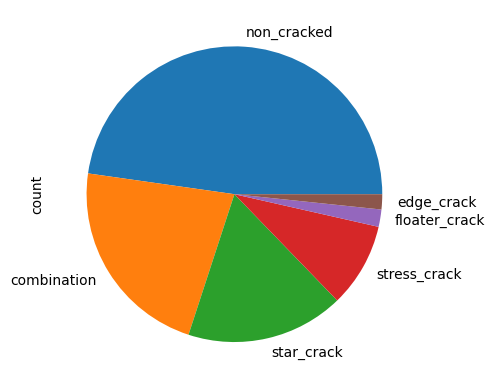

In [52]:
df['Label'].value_counts().plot.pie()

Balancing the Dataset for optimal results

In [53]:
sample_list=[]
max_size= 150 #We aim to balance the dataset by making all class values 150

#Undersampling groups having more than 100 values
groups=df.groupby('Label')
for label in df['Label'].unique():                 
    group=groups.get_group(label)
    sample_count=len(group)    
    if sample_count> max_size:
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
    else:
        samples=group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
    sample_list.append(samples)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))     
print (df['Label'].value_counts())

371
Label
non_cracked      150
combination       94
star_crack        73
stress_crack      39
floater_crack      8
edge_crack         7
Name: count, dtype: int64


In [54]:
#Oversampling groups having less than 100 values buy generating augmented images
import shutil
#Creating directory to hold augmented images
working_dir=r'C:\dataset\final'
aug_dir=os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['Label'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))


['combination', 'edge_crack', 'floater_crack', 'non_cracked', 'star_crack', 'stress_crack']


In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target=150 # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
groups=df.groupby('Label') # group by class
for label in df['Label'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    if sample_count< target: # if the class has less than target number of images
        aug_img_count=0
        delta=target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe( group,  x_col='Path', y_col=None, target_size=(150,150), class_mode=None, batch_size=1,
                                         shuffle=False, save_to_dir=target_dir, save_prefix='aug-',save_format='jpg')
        while aug_img_count<delta:
            images=next(aug_gen)            
            aug_img_count += len(images) 

Found 94 validated image filenames.
Found 7 validated image filenames.
Found 8 validated image filenames.
Found 73 validated image filenames.
Found 39 validated image filenames.


c:\Users\guest1\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [56]:
#Rearranging
aug_fpaths=[]
aug_labels=[]
classlist=os.listdir(aug_dir)
for klass in classlist:
    classpath=os.path.join(aug_dir, klass)     
    flist=os.listdir(classpath)    
    for f in flist:        
        fpath=os.path.join(classpath,f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries=pd.Series(aug_fpaths, name='Path')
Lseries=pd.Series(aug_labels, name='Label')
aug_df=pd.concat([Fseries, Lseries], axis=1)
print ('length of aug_df" ', len(aug_df))
df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
df=df.sample(frac=1.0, replace=False, random_state=42, axis=0).reset_index(drop=True)
print ('length of train_df is: ', len(df)) 
print (df['Label'].value_counts())       

length of aug_df"  529
length of train_df is:  900
Label
combination      150
stress_crack     150
non_cracked      150
floater_crack    150
star_crack       150
edge_crack       150
Name: count, dtype: int64


In [57]:
df.to_csv('balanced_dataset.csv')

In [58]:
len(df)

900

In [27]:
train_df=df.sample(frac=0.8, replace=True, random_state=42, axis=0).reset_index(drop=True)

In [39]:
train_df

,Path,Label
0,C:\dataset\final\non_cracked\000031.jpg,non_cracked
1,C:\dataset\final\stress_crack\000006.jpg,stress_crack
2,C:\dataset\final\non_cracked\frame_238.jpg,non_cracked
3,C:\dataset\final\aug\floater_crack\aug-_1_2485...,floater_crack
4,C:\dataset\final\aug\edge_crack\aug-_6_2288559...,edge_crack
...,...,...
715,C:\dataset\final\star_crack\frame_89.jpg,star_crack
716,C:\dataset\final\aug\stress_crack\aug-_18_7166...,stress_crack
717,C:\dataset\final\aug\combination\aug-_13_28774...,combination
718,C:\dataset\final\star_crack\frame_118.jpg,star_crack


In [43]:
df_merged = df.merge(train_df, how="left", left_on=["Path","Label"], right_on=["Path","Label"], indicator=True)
test_df=df_merged.query("_merge == 'left_only'")[["Path","Label"]].reset_index(drop=True)

Train for binary classification

In [26]:
import splitfolders
folder=r'C:\dataset\classify'
splitfolders.ratio(folder,output=r'C:\dataset\classify',seed=42,ratio=(.8,.2))

Copying files: 2070 files [00:05, 400.99 files/s]


In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the data

train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=True)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                        featurewise_center=True)

train_generator = train_datagen.flow_from_directory(
        r'C:\dataset\classify\train',
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        r'C:\dataset\classify\val',
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical')

Found 1656 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


In [28]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the pre-trained layers
for layer in vgg16.layers:
    layer.trainable = False

# Add new classification layers on top of the pre-trained model
model = tf.keras.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='BinaryCrossentropy',
              metrics=['accuracy'],
              run_eagerly=True)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 14976930 (57.13 MB)
Trainable params: 262242 (1.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [29]:
print(len(train_generator))
print(len(validation_generator))

104
26


In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_generator,
      steps_per_epoch=len(train_generator)//16,
      epochs=10,
      callbacks=[callback],
      validation_data=validation_generator,
      validation_steps=len(validation_generator)//16)

c:\python\lib\site-packages\keras\src\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\python\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
6/6 [==============================] - 22s 4s/step - loss: 0.7756 - accuracy: 0.5417 - val_loss: 0.6457 - val_accuracy: 0.5625
Epoch 2/10
6/6 [==============================] - 21s 3s/step - loss: 0.6759 - accuracy: 0.6562 - val_loss: 0.6022 - val_accuracy: 0.9375
Epoch 3/10
6/6 [==============================] - 22s 4s/step - loss: 0.6183 - accuracy: 0.7604 - val_loss: 0.6067 - val_accuracy: 0.7500
Epoch 4/10
6/6 [==============================] - 21s 4s/step - loss: 0.6263 - accuracy: 0.7292 - val_loss: 0.5372 - val_accuracy: 0.9375
Epoch 5/10
6/6 [==============================] - 20s 3s/step - loss: 0.5950 - accuracy: 0.7386 - val_loss: 0.5429 - val_accuracy: 0.9375
Epoch 6/10
6/6 [==============================] - 22s 4s/step - loss: 0.5580 - accuracy: 0.7604 - val_loss: 0.4688 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 21s 4s/step - loss: 0.5417 - accuracy: 0.7917 - val_loss: 0.4875 - val_accuracy: 0.7500
Epoch 8/10
6/6 [==================

Initial

In [36]:
model.evaluate(validation_generator)

3/3 [==============================] - 4s 1s/step - loss: 0.1267 - accuracy: 0.9651


[0.12665648758411407, 0.9651162624359131]

In [37]:
model.save('classify.h5')

c:\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training-2

In [61]:
model.evaluate(validation_generator)

3/3 [==============================] - 4s 1s/step - loss: 0.1553 - accuracy: 0.9651


[0.15530917048454285, 0.9651162624359131]

With bigger dataset

In [14]:
model.evaluate(validation_generator)

28/28 [==============================] - 21s 753ms/step - loss: 0.3907 - accuracy: 0.9176


[0.3906921148300171, 0.9176201224327087]

Edit

In [31]:
model.evaluate(validation_generator)

26/26 [==============================] - 21s 788ms/step - loss: 0.3984 - accuracy: 0.9179


[0.39835748076438904, 0.9178743958473206]

In [41]:
model.save('classify.h5')

c:\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Predict

In [40]:
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np

image=r'C:\Users\guest1.OTLBLRDSK008\Desktop\Project\samples\img7.jpg'
img = load_img(image, target_size=(150, 150))
img = img.resize((150,150))
img = img_to_array(img)
img = img.astype('float32')
img = img / 255.0
img = np.expand_dims(img,axis=0)
print(img.shape)
out = np.squeeze(model.predict(img))
out


(1, 150, 150, 3)
1/1 [==============================] - 0s 100ms/step


array([0.45086354, 0.79929143], dtype=float32)

Oversampling using augmentation

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
target=1000  # set the target count for each class in df
gen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
                              height_shift_range=.2, zoom_range=.2)
path=r'C:\dataset\classify\non_cracked'
lst=[]
for a in os.listdir(path):
     lst.append(os.path.join(path, a))
group=pd.DataFrame(lst,columns=['Path'])
print(group)
sample_count=len(group)   # determine how many samples there are in this class  
print(sample_count)
if sample_count< target: # if the class has less than target number of images
    aug_img_count=0
    delta=target-sample_count  # number of augmented images to create
    target_dir=path  # define where to write the images    
    aug_gen=gen.flow_from_dataframe( group,  x_col='Path', y_col=None, target_size=(600,600), class_mode=None, batch_size=1,
                                        shuffle=False, save_to_dir=target_dir, save_prefix='aug_',save_format='jpg')
    while aug_img_count<delta:
        images=next(aug_gen)            
        aug_img_count += len(images) 


                                              Path
0       C:\dataset\classify\non_cracked\000001.jpg
1       C:\dataset\classify\non_cracked\000002.jpg
2       C:\dataset\classify\non_cracked\000004.jpg
3       C:\dataset\classify\non_cracked\000010.jpg
4       C:\dataset\classify\non_cracked\000011.jpg
..                                             ...
197  C:\dataset\classify\non_cracked\frame_355.jpg
198  C:\dataset\classify\non_cracked\frame_356.jpg
199  C:\dataset\classify\non_cracked\frame_357.jpg
200  C:\dataset\classify\non_cracked\frame_358.jpg
201  C:\dataset\classify\non_cracked\frame_359.jpg

[202 rows x 1 columns]
202
Found 202 validated image filenames.


In [71]:
group.iloc[57,:]

Path    C:\new_dataset\images_2\img61_2.jpg
Name: 57, dtype: object

In [ ]:
import datetime 
import pandas as pd
# using now() to get current time
current_time = datetime.datetime.now()


In [10]:
import xlsxwriter

wb = xlsxwriter.Workbook('merging.xlsx')
ws = wb.add_worksheet()

mf = wb.add_format({'align': 'center', 'valign': 'vcenter'})
ws.merge_range(1, 1, 2, 2, 'an old falcon', mf)

ws.merge_range('E5:G5', 'misty mountains', mf)

wb.close()

2023-09-01 12:01:30.442 
  command:

    streamlit run C:\Users\guest1.OTLBLRDSK008\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py [ARGUMENTS]


False